# ESS-regularized Zwanzig Reweighted Fine-Tuning Analysis
This notebook analyzes the reweighted free energy residual CDFs of the refitting experiment `.pkl` data.

One analysis is performed for each experiment (i.e., combination of rank $r$ for refitting and train/validate/test data split.)


In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import pickle
import os
import numpy as np
from jax import numpy as jnp
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator

from timemachine.fe.refitting import load_pkl_data, compute_95_ci_ecdf
from timemachine.fe.refitting import EMBED_DIM, BETA
from timemachine.constants import KCAL_TO_KJ
from scipy.stats import cramervonmises_2samp
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
KT_TO_KCAL = 1. / BETA / KCAL_TO_KJ

The OpenEye Toolkits are found to be installed but not licensed and therefore will not be used.
The OpenEye Toolkits require a (free for academics) license, see https://docs.eyesopen.com/toolkits/python/quickstart-python/license.html
The OpenEye Toolkits are found to be installed but not licensed and therefore will not be used.
The OpenEye Toolkits require a (free for academics) license, see https://docs.eyesopen.com/toolkits/python/quickstart-python/license.html


In [2]:
def rmse(arr1, arr2):
    return jnp.sqrt(jnp.mean((arr1 - arr2)**2))

def singular_bootstrap_improvement(key, exp_dgs, orig_calc_dgs, reweight_calc_dgs):
    num_dgs = len(exp_dgs)
    key1, key2 = jax.random.split(key, num=2)
    bs_idxs1 = jax.random.choice(key1, jnp.arange(num_dgs), shape=(num_dgs,), replace=True)
    bs_idxs2 = jax.random.choice(key2, jnp.arange(num_dgs), shape=(num_dgs,), replace=True)

    orig_rmses = rmse(exp_dgs[bs_idxs1], orig_calc_dgs[bs_idxs1])
    new_rmses = rmse(exp_dgs[bs_idxs2], reweight_calc_dgs[bs_idxs2])
    return orig_rmses, new_rmses 

will use `train_frac = 0.75`, `num_pcs = 100` since it shows the largest validation improvement (w/ more than 100 test samples)

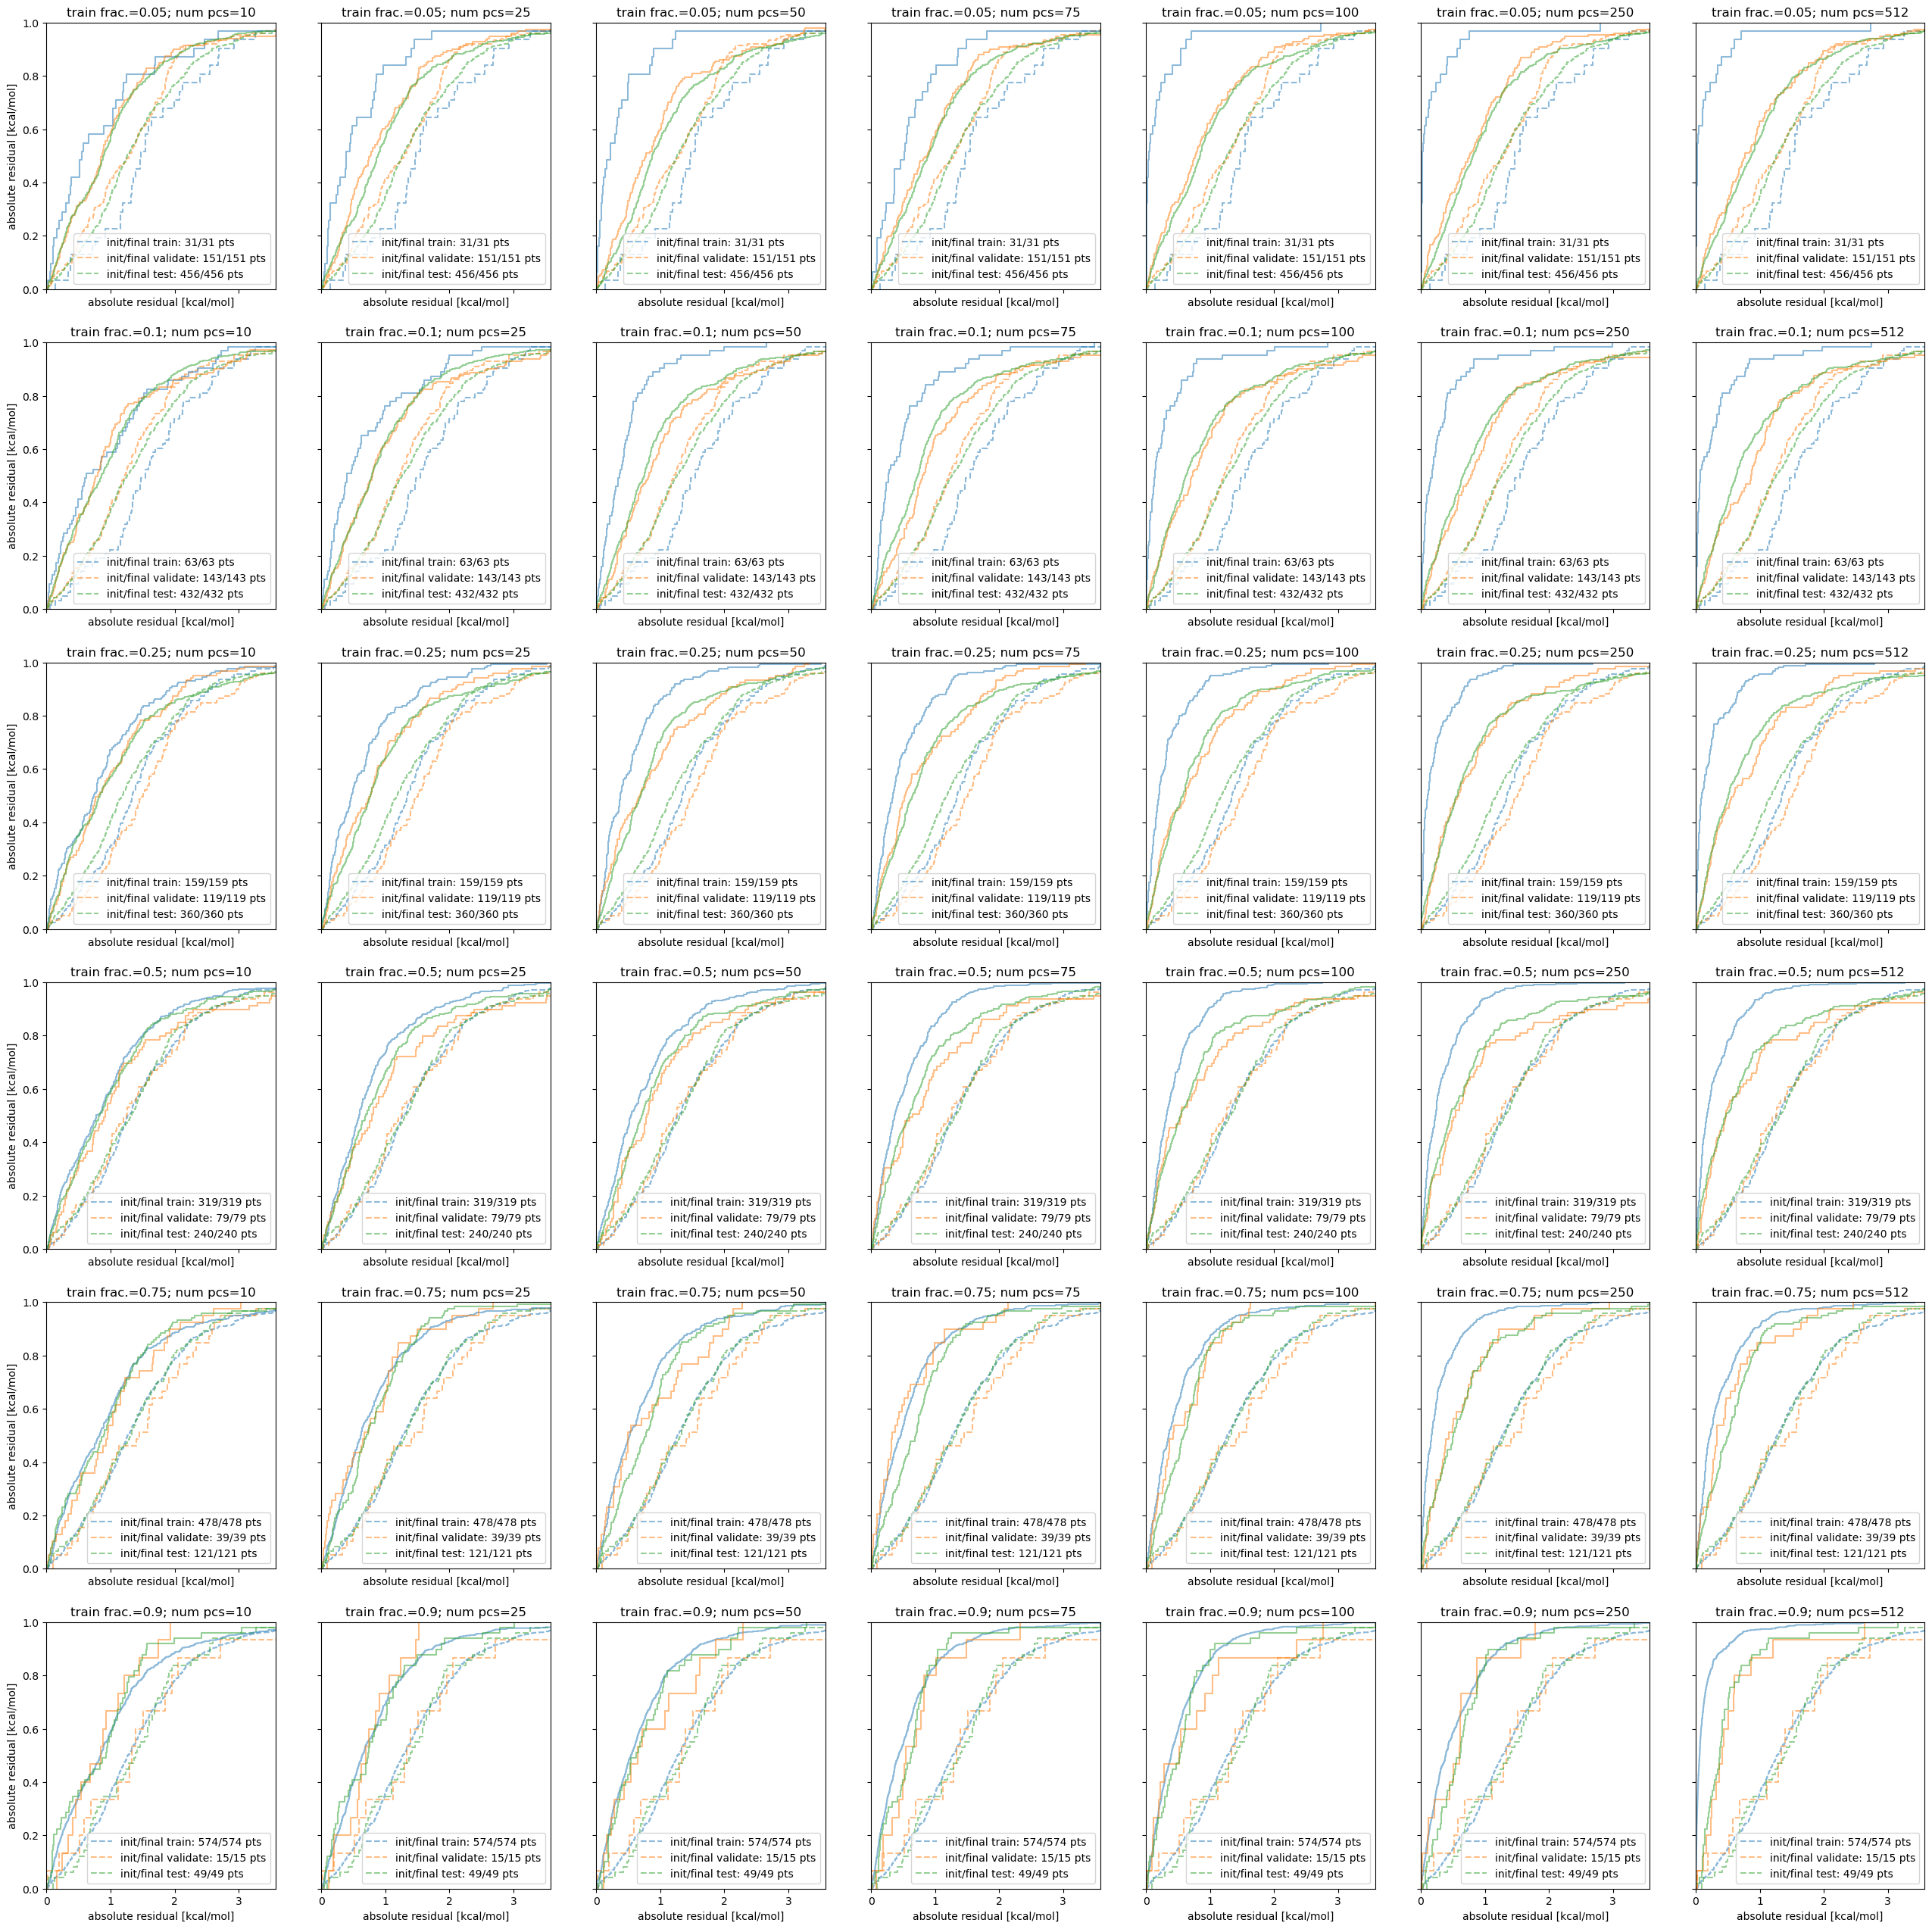

In [6]:
USE_ML = False
RETRIEVE_BY_DESCENT = False
CUTOFF_NESS_THRESHOLD = 0.1
nESS_on_test = True

drmse_dict = {}

fig, axes = plt.subplots(6,7, figsize=(32, 32), sharex=True, sharey=True)
for col_idx, num_pcs in enumerate([10, 25, 50, 75, 100, 250, EMBED_DIM]):
    for row_idx, train_fraction in enumerate([0.05, 0.1, 0.25, 0.5, 0.75, 0.9]):
        data = load_pkl_data(f"{num_pcs}_{RETRIEVE_BY_DESCENT}_{train_fraction}_{USE_ML}_{nESS_on_test}.t5.freesolv.pkl")
        [(res, callback_counter), params, train_loss_auxs, test_loss_auxs, validate_loss_auxs, train_idxs, test_idxs, validate_idxs, cache] = data
        
        # train
        (tr_ESS, tr_delta_us, tr_orig_calc_dg, 
         tr_reweighted_solv_dg, tr_reweighted_solv_ddg, 
         tr_exp_dg, tr_ligand_tm_charges, tr_orig_es_ss, tr_mod_es_ss) = train_loss_auxs
        
        # test
        (te_ESS, te_delta_us, te_orig_calc_dg, 
         te_reweighted_solv_dg, te_reweighted_solv_ddg, 
         te_exp_dg, te_ligand_tm_charges, te_orig_es_ss, te_mod_es_ss) = test_loss_auxs

        # validate
        (vl_ESS, vl_delta_us, vl_orig_calc_dg, 
         vl_reweighted_solv_dg, vl_reweighted_solv_ddg, 
         vl_exp_dg, vl_ligand_tm_charges, vl_orig_es_ss, vl_mod_es_ss) = validate_loss_auxs
        
        # plot the ECDF of the init resid dgs (pre)
        train_init_rmse = rmse(tr_orig_calc_dg, tr_exp_dg)
        validate_init_rmse = rmse(vl_orig_calc_dg, vl_exp_dg)
        test_init_rmse = rmse(te_orig_calc_dg, te_exp_dg)
        
        train_abs_resids = np.abs(tr_orig_calc_dg - tr_exp_dg)
        test_abs_resids = np.abs(te_orig_calc_dg - te_exp_dg)
        validate_abs_resids = np.abs(vl_orig_calc_dg - vl_exp_dg)
        
        train_final_resids = np.abs(tr_reweighted_solv_dg - tr_exp_dg)
        validate_final_resids = np.abs(vl_reweighted_solv_dg - vl_exp_dg)
        test_final_resids = np.abs(te_reweighted_solv_dg - te_exp_dg)

        mod_train_final_resids = np.where(tr_ESS >= CUTOFF_NESS_THRESHOLD, train_final_resids, -1.)
        mod_train_final_resids = np.array([q for q in mod_train_final_resids if q > 0.])

        mod_validate_final_resids = np.where(vl_ESS >= CUTOFF_NESS_THRESHOLD, validate_final_resids, -1.)
        mod_validate_final_resids = np.array([q for q in mod_validate_final_resids if q > 0.])

        mod_test_final_resids = np.where(te_ESS >= CUTOFF_NESS_THRESHOLD, test_final_resids, -1.)
        mod_test_final_resids = np.array([q for q in mod_test_final_resids if q > 0.])

        axes[row_idx, col_idx].ecdf(np.array(train_abs_resids) * KT_TO_KCAL, color=default_colors[0], 
                                    label=f"init/final train: {len(train_abs_resids)}/{len(mod_train_final_resids)} pts", ls='--', alpha=0.5)
        axes[row_idx, col_idx].ecdf(np.array(validate_abs_resids) * KT_TO_KCAL, color=default_colors[1], 
                                    label=f"init/final validate: {len(validate_abs_resids)}/{len(mod_validate_final_resids)} pts", ls='--', alpha=0.5)
        axes[row_idx, col_idx].ecdf(np.array(test_abs_resids) * KT_TO_KCAL, color=default_colors[2], 
                                    label=f"init/final test: {len(test_abs_resids)}/{len(mod_test_final_resids)} pts", ls = '--', alpha=0.5)

        # rmse_improvement
        train_final_rmse = np.sqrt(np.mean(np.array([(i-j)**2 for i, j, k in zip(tr_reweighted_solv_dg, tr_exp_dg, tr_ESS) if k > CUTOFF_NESS_THRESHOLD])))
        validate_final_rmse = np.sqrt(np.mean(np.array([(i-j)**2 for i, j, k in zip(vl_reweighted_solv_dg, vl_exp_dg, vl_ESS) if k > CUTOFF_NESS_THRESHOLD])))
        test_final_rmse = np.sqrt(np.mean(np.array([(i-j)**2 for i, j, k in zip(te_reweighted_solv_dg, te_exp_dg, te_ESS) if k > CUTOFF_NESS_THRESHOLD])))
        
        train_drmse = train_init_rmse - train_final_rmse
        validate_drmse = validate_init_rmse - validate_final_rmse
        test_drmse = test_init_rmse - test_final_rmse

        # append
        drmse_dict[(train_fraction, num_pcs)] = [train_drmse, validate_drmse, test_drmse]

        if len(mod_train_final_resids) > 2:
            axes[row_idx, col_idx].ecdf(mod_train_final_resids * KT_TO_KCAL, color=default_colors[0], 
                                        ls='-', alpha=0.5)
        if len(mod_validate_final_resids) > 2:
            axes[row_idx, col_idx].ecdf(mod_validate_final_resids * KT_TO_KCAL, color=default_colors[1], 
                                         ls='-', alpha=0.5)
        if len(mod_test_final_resids) > 2:
            axes[row_idx, col_idx].ecdf(mod_test_final_resids * KT_TO_KCAL, color=default_colors[2], 
                                         ls='-', alpha = 0.5)

        axes[row_idx, col_idx].set_title(f"train frac.={train_fraction}; num pcs={num_pcs}")
        axes[row_idx, col_idx].set_xlabel(f"absolute residual [kcal/mol]")
        if col_idx == 0:
            axes[row_idx, col_idx].set_ylabel(f"absolute residual [kcal/mol]")
        axes[row_idx, col_idx].set_xlim(0, 6 * KT_TO_KCAL)
        axes[row_idx, col_idx].legend()

plt.savefig("cdf_grid.pdf", format="pdf", dpi=300)

1. we want to compute the Cramer-von Mises statistic T and p-value for each experiment's train, validate, and test

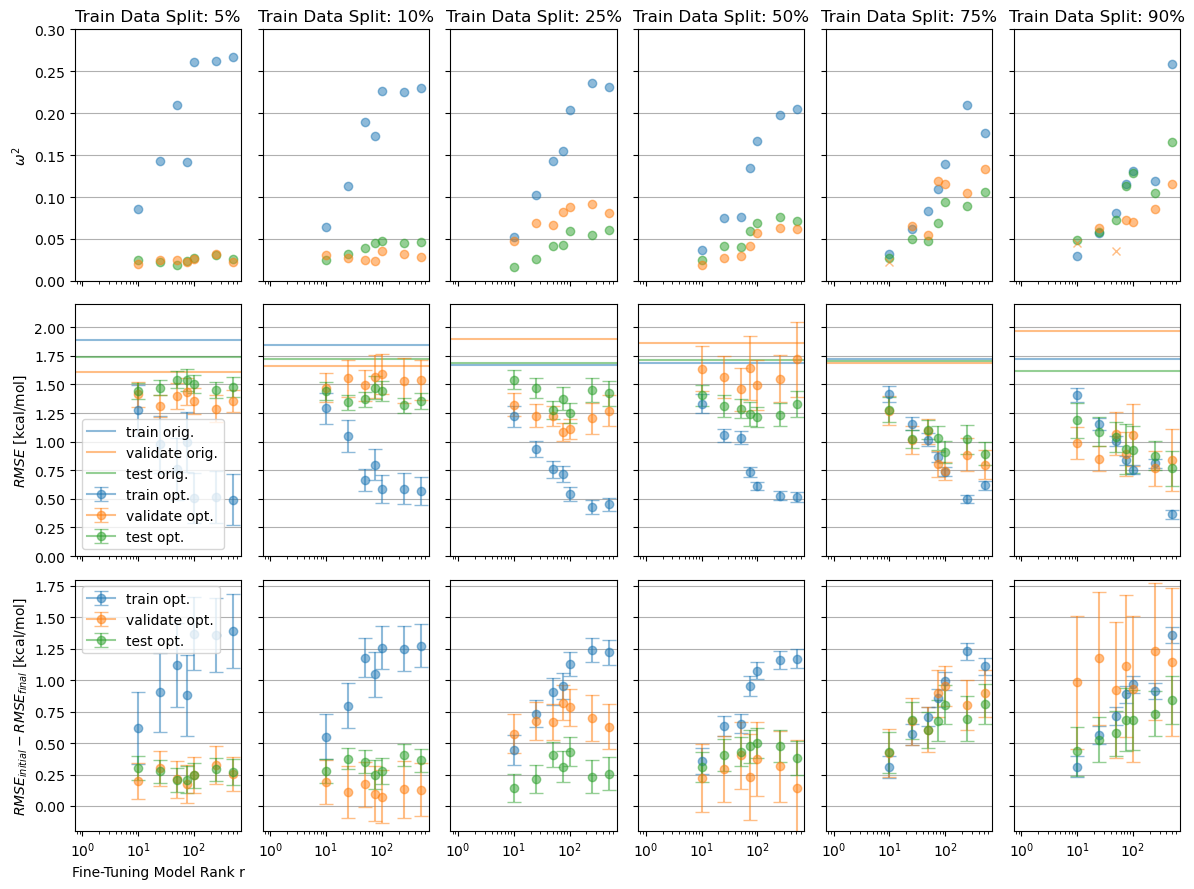

In [17]:
USE_ML = False
RETRIEVE_BY_DESCENT = False
CUTOFF_NESS_THRESHOLD = 0.1
nESS_on_test = True
alpha = 0.05
key = jax.random.PRNGKey(32)

drmse_dict = {}

fig, axes = plt.subplots(3,6, figsize=(12, 9), sharex=True, sharey=False)
for col_idx, num_pcs in enumerate([10, 25, 50, 75, 100, 250, EMBED_DIM]):
    for row_idx, train_fraction in enumerate([0.05, 0.1, 0.25, 0.5, 0.75, 0.9]):
        key, run_key = jax.random.split(key)
        data = load_pkl_data(f"{num_pcs}_{RETRIEVE_BY_DESCENT}_{train_fraction}_{USE_ML}_{nESS_on_test}.t5.freesolv.pkl")
        [(res, callback_counter), params, train_loss_auxs, test_loss_auxs, validate_loss_auxs, train_idxs, test_idxs, validate_idxs, cache] = data
        
        # train
        (tr_ESS, tr_delta_us, tr_orig_calc_dg, 
         tr_reweighted_solv_dg, tr_reweighted_solv_ddg, 
         tr_exp_dg, tr_ligand_tm_charges, tr_orig_es_ss, tr_mod_es_ss) = train_loss_auxs
        
        # test
        (te_ESS, te_delta_us, te_orig_calc_dg, 
         te_reweighted_solv_dg, te_reweighted_solv_ddg, 
         te_exp_dg, te_ligand_tm_charges, te_orig_es_ss, te_mod_es_ss) = test_loss_auxs

        # validate
        (vl_ESS, vl_delta_us, vl_orig_calc_dg, 
         vl_reweighted_solv_dg, vl_reweighted_solv_ddg, 
         vl_exp_dg, vl_ligand_tm_charges, vl_orig_es_ss, vl_mod_es_ss) = validate_loss_auxs
        
        # compute absolute residuals for each 
        train_abs_resids = np.abs(tr_orig_calc_dg - tr_exp_dg) * KT_TO_KCAL
        test_abs_resids = np.abs(te_orig_calc_dg - te_exp_dg) * KT_TO_KCAL
        validate_abs_resids = np.abs(vl_orig_calc_dg - vl_exp_dg) * KT_TO_KCAL

        train_final_resids = np.abs(tr_reweighted_solv_dg - tr_exp_dg) * KT_TO_KCAL
        test_final_resids = np.abs(te_reweighted_solv_dg - te_exp_dg) * KT_TO_KCAL
        validate_final_resids = np.abs(vl_reweighted_solv_dg - vl_exp_dg) * KT_TO_KCAL
        
        N_train, N_test, N_validate = len(train_final_resids), len(test_final_resids), len(validate_final_resids)
        factor_train, factor_test, factor_validate = 2. / N_train, 2. / N_test, 2. / N_validate

        # cramer von mises comparison for each
        train_res = cramervonmises_2samp(train_abs_resids, train_final_resids)
        test_res = cramervonmises_2samp(test_abs_resids, test_final_resids)
        validate_res = cramervonmises_2samp(validate_abs_resids, validate_final_resids)

        # absolute residual change
        tr_key, vl_key, te_key = jax.random.split(run_key, num=3)
        train_rmses_orig, train_rmses_new = jax.vmap(singular_bootstrap_improvement, in_axes=(0,None,None,None))(
            jax.random.split(tr_key, num=1000), jnp.array(tr_exp_dg), jnp.array(tr_orig_calc_dg), jnp.array(tr_reweighted_solv_dg))
        test_rmses_orig, test_rmses_new = jax.vmap(singular_bootstrap_improvement, in_axes=(0,None,None,None))(
            jax.random.split(te_key, num=1000), jnp.array(te_exp_dg), jnp.array(te_orig_calc_dg), jnp.array(te_reweighted_solv_dg))
        validate_rmses_orig, validate_rmses_new = jax.vmap(singular_bootstrap_improvement, in_axes=(0,None,None,None))(
            jax.random.split(vl_key, num=1000), jnp.array(vl_exp_dg), jnp.array(vl_orig_calc_dg), jnp.array(vl_reweighted_solv_dg))

        idx_to_label = ["train", "validate", "test"]

        for idx, data in enumerate([
            [train_rmses_orig, train_rmses_new], 
            [validate_rmses_orig, validate_rmses_new], 
            [test_rmses_orig, test_rmses_new]]):
            
            orig_data, new_data = data
            orig_data_mean, new_data_mean = jnp.mean(orig_data), jnp.mean(new_data)
            orig_data_std, new_data_std = jnp.std(orig_data), jnp.std(new_data)
            
            #print(train_change_mean, train_change_lower, train_change_upper)
            # only plot original data if num_pcs == 10 (data are same for each label set)
            if num_pcs == 10:
                axes[1, row_idx].axhline(
                    y = orig_data_mean * KT_TO_KCAL, 
                    ls='-', color=default_colors[idx], alpha=0.5, 
                    label=f"{idx_to_label[idx]} orig." if num_pcs == 10 else None)

            axes[1, row_idx].errorbar(
                num_pcs, new_data_mean * KT_TO_KCAL, 
                yerr=new_data_std * KT_TO_KCAL,
                marker='o', capsize=5, color=default_colors[idx], 
                alpha=0.5, label=f"{idx_to_label[idx]} opt." if num_pcs == 10 else None)
            axes[1,row_idx].set_ylim(0, 2.2)

            axes[2, row_idx].errorbar(
                num_pcs, (orig_data_mean - new_data_mean) * KT_TO_KCAL , 
                yerr=np.sqrt(new_data_std**2 + orig_data_std**2) * KT_TO_KCAL,
                marker='o', capsize=5, color=default_colors[idx], 
                alpha=0.5, label=f"{idx_to_label[idx]} opt." if num_pcs == 10 else None)
            axes[2,row_idx].set_ylim(-0.2, 1.8)


        # \omega^2
        axes[0, row_idx].plot(
            [num_pcs], [factor_train * train_res.statistic], marker = 'x' if train_res.pvalue > alpha else 'o', color = default_colors[0], 
            label=f"train" if row_idx == 0 else None, alpha=0.5)
        axes[0, row_idx].plot(
            [num_pcs], [factor_test * test_res.statistic], marker = 'x' if test_res.pvalue > alpha else 'o', color = default_colors[2], 
            label=f"test" if row_idx == 0 else None, alpha=0.5)
        axes[0,row_idx].plot(
            [num_pcs], [factor_validate * validate_res.statistic], marker = 'x' if validate_res.pvalue > alpha else 'o', color = default_colors[1], 
            label=f"validate" if row_idx == 0 else None, alpha=0.5)
        

        axes[0, row_idx].set_title(f"Train Data Split: {train_fraction*100:.0f}%")
        #axes[row_idx].legend()
        axes[0, row_idx].set_ylim(0., 0.3)
        axes[0, row_idx].grid(axis='y')
        axes[1, row_idx].grid(axis='y')
        axes[2, row_idx].grid(axis='y')
        
        axes[0, row_idx].set_xscale('log')
        axes[1, row_idx].set_xscale('log')
        if row_idx > 0:
            axes[0, row_idx].set_yticklabels([])
            axes[1, row_idx].set_yticklabels([])
            axes[2, row_idx].set_yticklabels([])
            

axes[0, 0].set_ylabel(r"$\omega^2$")    
axes[1,0].set_ylabel(r"$RMSE$ [kcal/mol]")
axes[2,0].set_ylabel(r"$RMSE_{initial} - RMSE_{final}$ [kcal/mol]")
axes[2, 0].set_xlabel(f"Fine-Tuning Model Rank r")
axes[1,0].legend()
axes[2,0].legend()
plt.tight_layout()
plt.savefig("fig4_CvM_RMSE.pdf", format="pdf", dpi=300, bbox_inches = 'tight')